# Preprocessing Step
---

This notebook carrieds out the preprocessing steps for the metabolomics data.

## Input

### Libraries

In [1]:
# To use RCall for the first time, one needs to 
# the location of the R home directory.
firstTimeRCall = false
if firstTimeRCall
    using Pkg
    io = IOBuffer()
    versioninfo(io)
    if occursin("Windows", String(take!(io)))
        ENV["R_HOME"] = "C:/PROGRA~1/R/R-43~1.1" # from R.home() in R
    else 
        ENV["R_HOME"] = "/usr/lib/R"

    end
    Pkg.build("RCall")
end      

In [2]:
using CSV, DataFrames, Missings, CategoricalArrays
using StatsBase, Statistics, MultivariateStats, RCall
using FreqTables, Plots, StatsPlots

In [3]:
# Change display options
Base.displaysize() = (280, 88)

### Ext. Functions

In [4]:
include(joinpath(@__DIR__,"..","..","src","preprocessing.jl" ));
include(joinpath(@__DIR__,"..","..","src","utils.jl" ));

### Load data

In [5]:
# Load Negative
negMeta = realpath((@__DIR__)*"/../../data/data_primary/Elam_metabolites_2020_NEG_PH_cleaned_blkfil-batch-effect-analysis.csv")
dfNegMeta = DataFrame(CSV.File(negMeta));

negMetaKln = realpath((@__DIR__)*"/../../data/data_primary/Elam_metabolites-negative-2020_batch-corrected-all-data-elements.csv")
dfNegMetaKln = DataFrame(CSV.File(negMetaKln));

# Load Positive
posMeta = realpath(joinpath(@__DIR__,"..", "..","data","data_primary","Elam_metabolites_2020_POS_PH_cleaned_blkfil-batch-effect-analysis.csv" ))
dfPosMeta = DataFrame(CSV.File(posMeta));

posMetaKln = realpath(joinpath(@__DIR__,"..", "..","data","data_primary","Elam_metabolites-positive-2020_batch-corrected-all-data-elements.csv" ))
dfPosMetaKln = DataFrame(CSV.File(posMetaKln));

## Chain of preprocessing

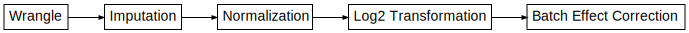

In [6]:
diGraph(["Wrangle", "Imputation", "Normalization", "Log2 Transformation", "Batch Effect Correction"])

## Wrangle data
----

### Metabolites reference dictionnary

We create a reference dictionnary for the metabolites name.

In [7]:
first(dfNegMeta)

,Sample,Group,Batch,Column4,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93
,String,String,String,Missing,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]n,Cntl,B1,missing,40448.1,31993.0


In [8]:
first(dfPosMeta)

,Sample,Group,Batch,N-ACETYL-DL-METHIONINE_214.0511-7.3,N-ACETYL-L-ASPARTIC ACID_158.0452-1.49
,String,String,String,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]p,Cntl,B1,6273.5,21874.6


In [9]:
# isCossRef = false
dfNegMeta, dfNegCrossRef = crossRefLipids(dfNegMeta, "negMeta", startCol = 5);
dfPosMeta, dfPosCrossRef = crossRefLipids(dfPosMeta, "posMeta", startCol = 4);

# # save cross reference
# dfNegCrossRef |> CSV.write("../data/dataprocessed/inl2b_NegMeta_Xref.csv");
# dfPosCrossRef |> CSV.write("../data/dataprocessed/inl2b_PosMeta_Xref.csv");

# merge neg and pos look up table
dfMetaCrossRef = deepcopy(dfNegCrossRef);
append!(dfMetaCrossRef, dfPosCrossRef)
# dfMetaCrossRef |> CSV.write("../data/dataprocessed/inl2b_Meta_Xref.csv");

In [10]:
dfPosCrossRef[949,:]

,lipID,OriginalNames
,String,String
949,posMeta949,_180.069-1.23


In [11]:
first(dfPosMeta)

,Sample,Group,Batch,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5
,String,String,String,Float64,Float64,Float64,Float64?,Float64
1,QE2_jdg_290_Elam_1[CN01]p,Cntl,B1,6273.5,21874.6,82296.1,1.36158e5,45237.7


### Create a Group variable: CN, CS, CSbaseline

Adjust for column name according to primary csv file.

In [12]:
# drop CLASS column 
dfNegMetaKln = select(dfNegMetaKln, Not(:CLASS));
rename!(dfNegMetaKln, :NAME=> :Sample);
# rename CLASS to Batch and copy batch info from dfNegMeta
rename!(dfPosMetaKln, :CLASS=> :Batch);
rename!(dfPosMetaKln, :NAME=> :Sample);
dfPosMetaKln.Batch = dfNegMetaKln.Batch;

In [13]:
dfNegMetaKln = addGroupCatMeta(dfNegMetaKln, false);
dfPosMetaKln = addGroupCatMeta(dfPosMetaKln, false);

Check group population:

In [14]:
countmap(dfNegMetaKln.Group; alg = :dict)

Dict{String, Int64} with 3 entries:
  "CN"         => 54
  "CS"         => 44
  "CSbaseline" => 44

In [15]:
first(dfNegMetaKln)

,Sample,Batch,Group,Fish Oil,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93
,String,String,String,String,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,Fish Oil,41793.5,36208.7


### Convert to categorical: Batch, Statin and Oil

In [16]:
dfNegMetaKln = catBGSF(dfNegMetaKln, false);
dfPosMetaKln = catBGSF(dfPosMetaKln, false);

In [17]:
dfNegMetaKln[3:7,:]

,Sample,Batch,Group,Statin,FishOil,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93
,String,String,String,String,String,Float64,Float64
1,QE2_jdg_291_Elam_3[CN03]n,B2,CN,yes,yes,35215.5,35926.4
2,QE2_jdg_290_Elam_4[CN04]n,B1,CN,yes,no,81099.1,31295.7
3,QE2_jdg_290_Elam_5[CN05]n,B1,CN,yes,yes,54202.7,22303.0
4,QE2_jdg_290_Elam_6[CN06]n,B1,CN,yes,no,53496.5,68528.5
5,QE2_jdg_290_Elam_7[CN07]n,B1,CN,yes,no,56615.3,37813.4


In [18]:
dfPosMetaKln[3:7,:]

,Sample,Batch,Group,Statin,FishOil,N-ACETYL-L-ASPARTIC ACID_158.0452-1.49
,String,String,String,String,String,Float64
1,QE2_jdg_291_Elam_3[CN03]p,B2,CN,yes,yes,15220.3
2,QE2_jdg_290_Elam_5[CN05]p,B1,CN,yes,no,8692.71
3,QE2_jdg_290_Elam_4[CN04]p,B1,CN,yes,yes,22346.4
4,QE2_jdg_290_Elam_6[CN06]p,B1,CN,yes,no,27282.5
5,QE2_jdg_290_Elam_7[CN07]p,B1,CN,yes,no,21432.9


### Check tables

In [19]:
freqtable(dfNegMetaKln, :Group, :Batch)

3×4 Named Matrix{Int64}
Group ╲ Batch │ B1  B2  B3  B4
──────────────┼───────────────
CN            │ 13  14  14  13
CS            │ 12  11  10  11
CSbaseline    │ 10  11  12  11

In [20]:
freqtable(dfNegMetaKln, :Group, :FishOil)

3×2 Named Matrix{Int64}
Group ╲ FishOil │  no  yes
────────────────┼─────────
CN              │  39   15
CS              │  26   18
CSbaseline      │  27   17

## Get original values with batch effect 

### Keep only IDs' sample and values

Keep only Sample IDs and metabolites'values of the original data an combine with `Group`, `Batch` and `Fish Oil` variables the corrected files.

Negative:

In [21]:
first(dfNegMeta)

,Sample,Group,Batch,Column4,negMeta1,negMeta2,negMeta3,negMeta4
,String,String,String,Missing,Float64,Float64,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]n,Cntl,B1,missing,40448.1,31993.0,55239.9,1.06007e5


Remove the columns: *Group, Batch and Column4*

In [23]:
select!(dfNegMeta, Not([:Group, :Batch, :Column4]));
first(dfNegMeta)

LoadError: ArgumentError: column name :Group not found in the data frame

Positive:

In [25]:
first(dfPosMeta)

,Sample,Group,Batch,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5
,String,String,String,Float64,Float64,Float64,Float64?,Float64
1,QE2_jdg_290_Elam_1[CN01]p,Cntl,B1,6273.5,21874.6,82296.1,1.36158e5,45237.7


In [26]:
select!(dfPosMeta, Not([:Group, :Batch]));
first(dfPosMeta)

,Sample,posMeta1,posMeta2,posMeta3,posMeta4,posMeta5,posMeta6
,String,Float64,Float64,Float64,Float64?,Float64,Float64?
1,QE2_jdg_290_Elam_1[CN01]p,6273.5,21874.6,82296.1,1.36158e5,45237.7,1.79344e5


### Check that metabolites column names are similar

In [27]:
vNameNegMeta = names(dfNegMeta)[2:end];
vNamePosMeta = names(dfPosMeta)[2:end];

vNameNegMetaKln = names(dfNegMetaKln)[6:end];
vNamePosMetaKln = names(dfPosMetaKln)[6:end];

Check length:

In [28]:
DataFrame(Meta = ["Neg", "Pos"], 
      NotClean = [length(vNameNegMeta), length(vNamePosMeta)],
      Clean = [length(vNameNegMetaKln), length(vNamePosMetaKln)])

,Meta,NotClean,Clean
,String,Int64,Int64
1,Neg,1251,1251
2,Pos,1867,1856


### Join info fom corrected data set to original values

In [29]:
first(dfNegMetaKln)

,Sample,Batch,Group,Statin,FishOil,PYRUVATE_221.0301-1.37,CITRATE_173.0086-1.93
,String,String,String,String,String,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,yes,yes,41793.5,36208.7


In [30]:
select!(dfNegMetaKln, [:Sample, :Batch, :Group, :Statin, :FishOil]);
select!(dfPosMetaKln, [:Sample, :Batch, :Group, :Statin, :FishOil]);

Left-join to the original values:

In [31]:
dfNegMeta = leftjoin(dfNegMetaKln, dfNegMeta, on= :Sample)
first(dfNegMeta, 5)

,Sample,Batch,Group,Statin,FishOil,negMeta1,negMeta2,negMeta3
,String,String,String,String,String,Float64?,Float64?,Float64?
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,yes,yes,40448.1,31993.0,55239.9
2,QE2_jdg_292_Elam_2[CN02]n,B3,CN,yes,yes,41433.2,37152.7,67478.6
3,QE2_jdg_291_Elam_3[CN03]n,B2,CN,yes,yes,50597.4,31512.6,1.96822e5
4,QE2_jdg_290_Elam_4[CN04]n,B1,CN,yes,no,62621.4,27829.2,41192.5
5,QE2_jdg_290_Elam_5[CN05]n,B1,CN,yes,yes,47448.5,20208.0,1.66819e5


In [32]:
dfPosMeta = leftjoin(dfPosMetaKln, dfPosMeta, on= :Sample);
first(dfPosMeta,5)

,Sample,Batch,Group,Statin,FishOil,posMeta1,posMeta2,posMeta3
,String,String,String,String,String,Float64?,Float64?,Float64?
1,QE2_jdg_290_Elam_1[CN01]p,B1,CN,yes,yes,6273.5,21874.6,82296.1
2,QE2_jdg_292_Elam_2[CN02]p,B3,CN,yes,yes,85251.4,11345.7,61212.3
3,QE2_jdg_291_Elam_3[CN03]p,B2,CN,yes,yes,27195.9,14630.8,2.72754e5
4,QE2_jdg_290_Elam_5[CN05]p,B1,CN,yes,no,24927.6,9562.45,1.52612e5
5,QE2_jdg_290_Elam_4[CN04]p,B1,CN,yes,yes,18450.3,21745.7,2.36944e5


## Impute missing data  
---
HM (Half of the Minimum): This method replaces missing elements with half of the minimum of non-missing elements in the corresponding variable.

In [33]:
dfNegMeta = imputeHM(dfNegMeta, startCol = 6);
dfPosMeta = imputeHM(dfPosMeta, startCol = 6);

In [34]:
findall(Matrix(dfNegMeta[:,6:end]) .=== missing)

CartesianIndex{2}[]

## Normalization
----

### Probabilistic Quotient Normalization

> 1. Perform an integral normalization (typically a constant
integral of 100 is used).
> 2. Choose/calculate the reference spectrum (the best approach
is the calculation of the median spectrum of control samples).
> 3. Calculate the quotients of all variables of interest of the test
spectrum with those of the reference spectrum.
> 4. Calculate the median of these quotients.
> 5. Divide all variables of the test spectrum by this median.


In [35]:
dfNegMeta = pqnorm(dfNegMeta, startCol = 6);
dfPosMeta = pqnorm(dfPosMeta, startCol = 6);

## Transformation
---

A simple and widely used transformation to make data more symmetric and homoscedastic is the log-transformation.

In [36]:
dfNegMeta = log2tx(dfNegMeta, startCol = 6);
dfPosMeta = log2tx(dfPosMeta, startCol = 6);

In [37]:
first(dfNegMeta)

,Sample,Batch,Group,Statin,FishOil,negMeta1,negMeta2,negMeta3
,String,String,String,String,String,Float64,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]n,B1,CN,yes,yes,-9.66108,-9.99939,-9.21144


## Adjusting for batch effects
---

### Check for batch effects

In [38]:
R"""
suppressMessages(library(mixOmics))
suppressMessages(library(tidyverse));
"""

RObject{StrSxp}
 [1] "forcats"   "stringr"   "dplyr"     "purrr"     "readr"     "tidyr"    
 [7] "tibble"    "tidyverse" "mixOmics"  "ggplot2"   "lattice"   "MASS"     
[13] "stats"     "graphics"  "grDevices" "utils"     "datasets"  "methods"  
[19] "base"     


In [39]:
dfNeg = catBGSF(dfNegMeta);

In [40]:
dfPos = catBGSF(dfPosMeta);

In [41]:
@rput dfNeg;
@rput dfPos;

In [42]:
R"summary(dfNeg[,c(1:5)])"

RObject{StrSxp}
    Sample          Batch          Group    Statin   FishOil 
 Length:142         B1:35   CN        :54   no :44   no :92  
 Class :character   B2:36   CS        :44   yes:98   yes:50  
 Mode  :character   B3:36   CSbaseline:44                    
                    B4:35                                    


In [43]:
# get matrix data
Xneg= copy(transpose(Matrix(dfNeg[:,6:end])));
Xpos= copy(transpose(Matrix(dfPos[:,6:end])));

# train a PCA model
Mneg = fit(PCA, Xneg; maxoutdim=10)
Mpos = fit(PCA, Xpos; maxoutdim=10)

PCA(indim = 1867, outdim = 10, principalratio = 0.5325476572329885)

In [44]:
size(Xneg)

(1251, 142)

In [45]:
# get explained variance
explainedVarPCAneg = principalvars(Mneg)./tvar(Mneg)
explainedVarPCApos = principalvars(Mpos)./tvar(Mpos);

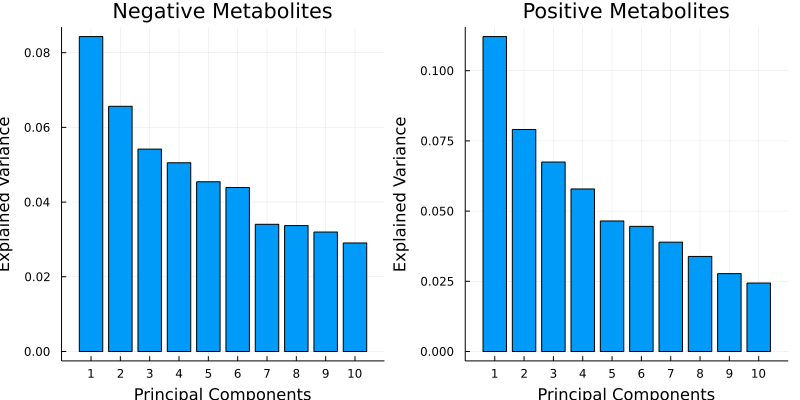

In [46]:
ticklabel = string.(collect(1:10))
pNeg =bar(explainedVarPCAneg, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Negative Metabolites")
xlabel!("Principal Components")
ylabel!("Explained Variance");

pPos =bar(explainedVarPCApos, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Positive Metabolites")
xlabel!("Principal Components")
ylabel!("Explained Variance");

plot(pNeg, pPos, size = (800, 400))

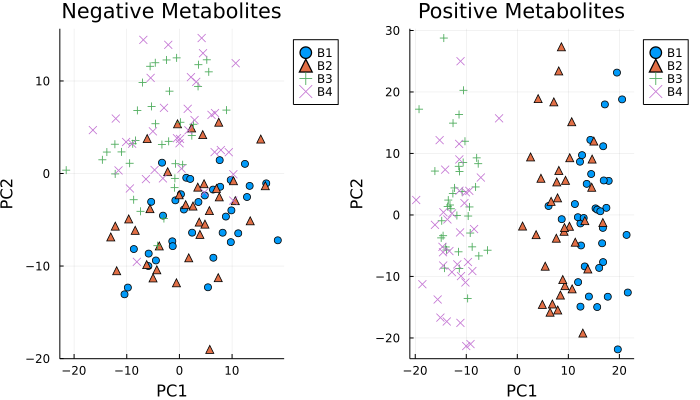

In [47]:
# get batch group labels
XbatchNeg = Vector(dfNeg[:,2]);
XbatchPos = Vector(dfPos[:,2]);

# apply PCA model 
Yneg = MultivariateStats.transform(Mneg, Xneg)
Ypos = MultivariateStats.transform(Mpos, Xpos)

# group results by testing set labels for color coding
B1neg = Yneg[:,XbatchNeg.=="B1"]; B1pos = Ypos[:,XbatchPos.=="B1"] 
B2neg = Yneg[:,XbatchNeg.=="B2"]; B2pos = Ypos[:,XbatchPos.=="B2"]
B3neg = Yneg[:,XbatchNeg.=="B3"]; B3pos = Ypos[:,XbatchPos.=="B3"]
B4neg = Yneg[:,XbatchNeg.=="B4"]; B4pos = Ypos[:,XbatchPos.=="B4"];

# visualize first 2 principal components
pNeg = scatter(B1neg[1,:],B1neg[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2neg[1,:],B2neg[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3neg[1,:],B3neg[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4neg[1,:],B4neg[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pNeg,xlabel="PC1",ylabel="PC2");

pPos = scatter(B1pos[1,:],B1pos[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2pos[1,:],B2pos[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3pos[1,:],B3pos[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4pos[1,:],B4pos[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pPos,xlabel="PC1",ylabel="PC2");

plot(pNeg, pPos, legend = :outertopright, title = ["Negative Metabolites" "Positive Metabolites"], size = (700, 400))

In [48]:
plotattr("size")

size {NTuple{2,Int}}
sizes, windowsize, wsize

(width_px, height_px) of the whole Plot
Plot attribute,  default: (600, 400)


### Lipids most influenced by batches

In [49]:
# Get variance explained
dfVarExplNeg = getVarExpl(Xneg, XbatchNeg, names(dfNeg)[6:end]);
dfVarExplPos = getVarExpl(Xpos, XbatchPos, names(dfPos)[6:end]);

In [50]:
first(dfVarExplNeg, 5)

,Lipids,VarExpl
,String,Float64
1,negMeta323,0.94102
2,negMeta125,0.923012
3,negMeta114,0.916264
4,negMeta765,0.901512
5,negMeta960,0.901315


In [51]:
first(dfVarExplPos, 5)

,Lipids,VarExpl
,String,Float64
1,posMeta1663,0.982033
2,posMeta1580,0.978721
3,posMeta1839,0.970537
4,posMeta1773,0.965097
5,posMeta1248,0.956792


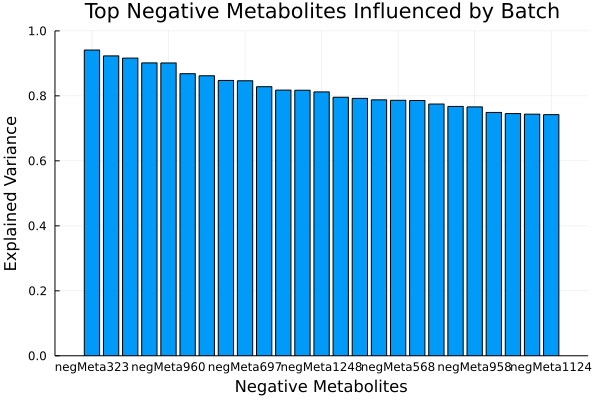

In [52]:
nTop = 25# sum(dfVarExpl.VarExpl>0.1)

ticklabel = dfVarExplNeg.Lipids[1:nTop]
pNeg =bar(dfVarExplNeg.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Negative Metabolites Influenced by Batch", ylims = (0, 1))
xlabel!("Negative Metabolites")
ylabel!("Explained Variance")

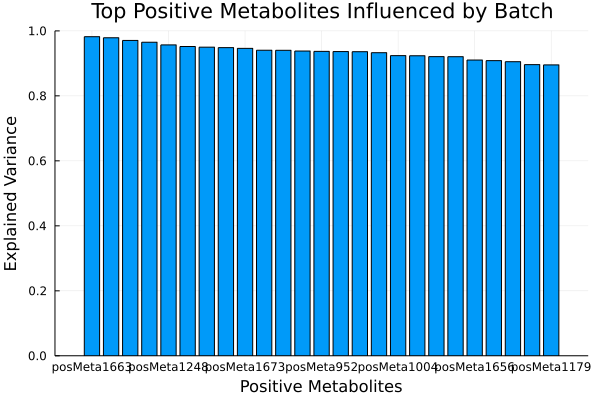

In [53]:
ticklabel = dfVarExplPos.Lipids[1:nTop]
pPos =bar(dfVarExplPos.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Positive Metabolites Influenced by Batch", ylims = (0, 1))
xlabel!("Positive Metabolites")
ylabel!("Explained Variance")

### Most influential batch 

In [54]:
adjRsquaredPerLipidsPerBatch = getVarExplPerMetaPerBatch(Xneg, XbatchNeg, dfVarExplNeg.Lipids); 

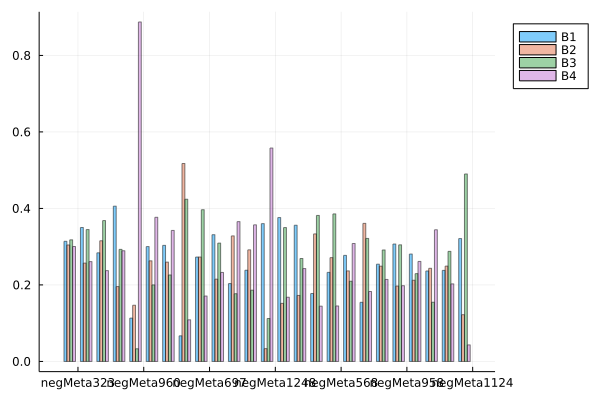

In [55]:
ticklabel = dfVarExplNeg.Lipids[1:nTop]
groupedbar(ticklabel, adjRsquaredPerLipidsPerBatch[1:nTop, :], 
    bar_position = :dodge, bar_width=0.7, alpha=0.5,
    xticks=(1:4:nTop, ticklabel[1:4:nTop]), 
    legend = :outertopright, label = ["B1" "B2" "B3" "B4"]
)

In [56]:
size(dfNeg)

(142, 1256)

## Correct batch effect with combat 

In [57]:
R"""
suppressMessages(library(sva))
fCombat <- function(myDf){
mLipids <- as.matrix(myDf[,c(-1,-2,-3,-4,-5)])

modcombat <- model.matrix(~1, data = myDf[,c(2,3,5)])

combatLipids <- ComBat(dat=t(mLipids), batch = myDf$Batch, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)

# modGroupFishOil <- model.matrix(~Group*FishOil, data = myDf[,c(2,3,5)])
# combatFit = lm.fit(modGroupFishOil, t(combatLipids))

return(combatLipids)
}

mLipidsBatchAdjNeg <- t(fCombat(dfNeg));
mLipidsBatchAdjPos <- t(fCombat(dfPos));

"""
@rget mLipidsBatchAdjNeg;
@rget mLipidsBatchAdjPos;

┌ Warning: RCall.jl: Found4batches
│ Adjusting for0covariate(s) or covariate level(s)
│ Standardizing Data across genes
│ Fitting L/S model and finding priors
│ Finding parametric adjustments
│ Adjusting the Data
│ 
└ @ RCall C:\Users\Fenril-Fractal\.julia\packages\RCall\iMDW2\src\io.jl:160
┌ Warning: RCall.jl: Found4batches
│ Adjusting for0covariate(s) or covariate level(s)
│ Standardizing Data across genes
│ Fitting L/S model and finding priors
│ Finding parametric adjustments
│ Adjusting the Data
│ 
└ @ RCall C:\Users\Fenril-Fractal\.julia\packages\RCall\iMDW2\src\io.jl:160


In [58]:
# get matrix data
Xneg= copy(transpose(mLipidsBatchAdjNeg));
Xpos= copy(transpose(mLipidsBatchAdjPos));

# train a PCA model
Mneg = fit(PCA, Xneg; maxoutdim=10)
Mpos = fit(PCA, Xpos; maxoutdim=10)

PCA(indim = 1867, outdim = 10, principalratio = 0.5014647642610622)

In [59]:
size(Xneg)

(1251, 142)

In [60]:
# get explained variance
explainedVarPCAneg = principalvars(Mneg)./tvar(Mneg)
explainedVarPCApos = principalvars(Mpos)./tvar(Mpos);

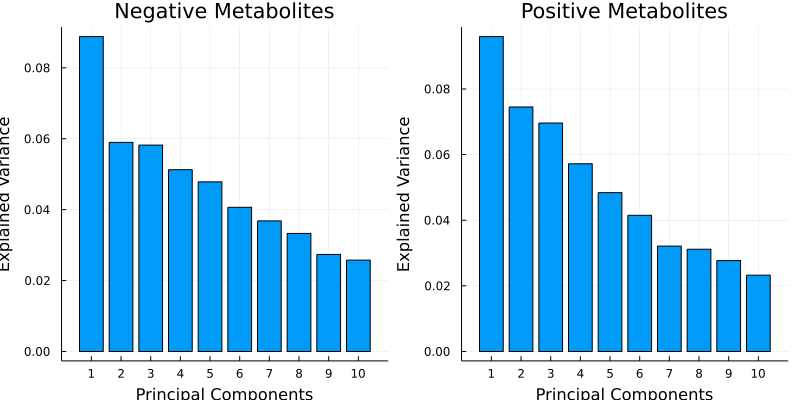

In [61]:
ticklabel = string.(collect(1:10))
pNeg =bar(explainedVarPCAneg, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Negative Metabolites")
xlabel!("Principal Components")
ylabel!("Explained Variance");

pPos =bar(explainedVarPCApos, orientation=:v, xticks=(1:10, ticklabel),
    yflip=false, legend = false, title = "Positive Metabolites")
xlabel!("Principal Components")
ylabel!("Explained Variance");

plot(pNeg, pPos, size = (800, 400))

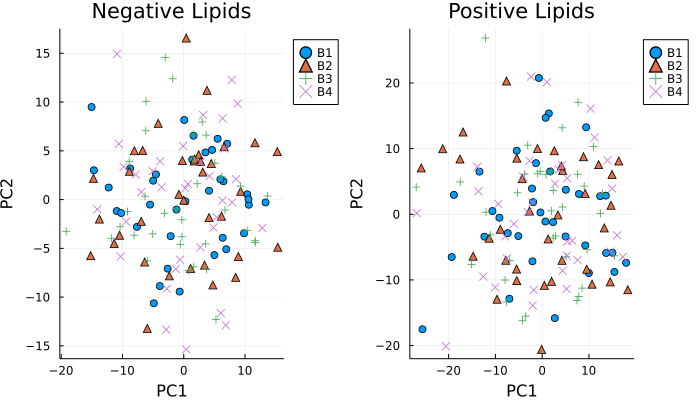

In [62]:
# get batch group labels
XbatchNeg = Vector(dfNeg[:,2]);
XbatchPos = Vector(dfPos[:,2]);

# apply PCA model 
Yneg = MultivariateStats.transform(Mneg, Xneg)
Ypos = MultivariateStats.transform(Mpos, Xpos)

# group results by testing set labels for color coding
B1neg = Yneg[:,XbatchNeg.=="B1"]; B1pos = Ypos[:,XbatchPos.=="B1"] 
B2neg = Yneg[:,XbatchNeg.=="B2"]; B2pos = Ypos[:,XbatchPos.=="B2"]
B3neg = Yneg[:,XbatchNeg.=="B3"]; B3pos = Ypos[:,XbatchPos.=="B3"]
B4neg = Yneg[:,XbatchNeg.=="B4"]; B4pos = Ypos[:,XbatchPos.=="B4"];

# visualize first 2 principal components
pNeg = scatter(B1neg[1,:],B1neg[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2neg[1,:],B2neg[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3neg[1,:],B3neg[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4neg[1,:],B4neg[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pNeg,xlabel="PC1",ylabel="PC2");

pPos = scatter(B1pos[1,:],B1pos[2,:], marker=:auto, markersize=4, linewidth=0, label = "B1")
scatter!(B2pos[1,:],B2pos[2,:], marker=:utriangle,linewidth=0, label = "B2")
scatter!(B3pos[1,:],B3pos[2,:], marker=:+,linewidth=0, label = "B3")
scatter!(B4pos[1,:],B4pos[2,:], marker=:x,linewidth=0, label = "B4")
plot!(pPos,xlabel="PC1",ylabel="PC2");

plot(pNeg, pPos, legend = :outertopright, title = ["Negative Lipids" "Positive Lipids"], size = (700, 400))

### Metabolites most influenced by batches after correction

In [63]:
# Get variance explained
dfVarExplNeg = getVarExpl(Xneg, XbatchNeg, names(dfNeg)[6:end]);
dfVarExplPos = getVarExpl(Xpos, XbatchPos, names(dfPos)[6:end]);

In [64]:
first(dfVarExplNeg, 5)

,Lipids,VarExpl
,String,Float64
1,negMeta323,0.0848483
2,negMeta960,0.0597171
3,negMeta125,0.0555615
4,negMeta114,0.0488235
5,negMeta765,0.0361576


In [65]:
first(dfVarExplPos, 5)

,Lipids,VarExpl
,String,Float64
1,posMeta1663,0.0757551
2,posMeta1580,0.059548
3,posMeta1839,0.041922
4,posMeta1773,0.023622
5,posMeta1248,0.0152308


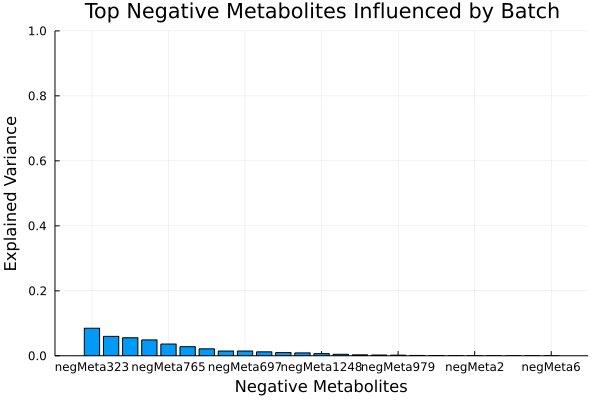

In [66]:
nTop = 25# sum(dfVarExpl.VarExpl>0.1)

ticklabel = dfVarExplNeg.Lipids[1:nTop]
pNeg =bar(dfVarExplNeg.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Negative Metabolites Influenced by Batch", ylims = (0, 1))
xlabel!("Negative Metabolites")
ylabel!("Explained Variance")

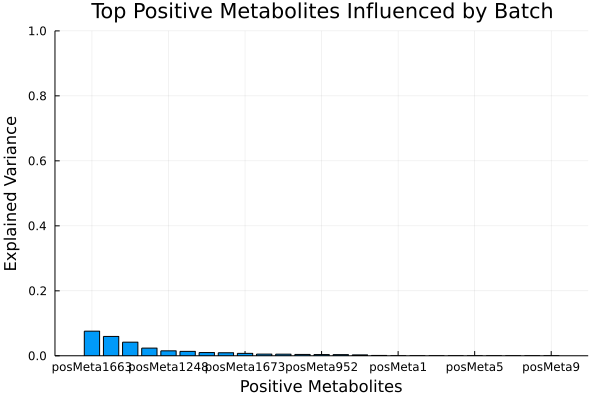

In [67]:
ticklabel = dfVarExplPos.Lipids[1:nTop]
pPos =bar(dfVarExplPos.VarExpl[1:nTop], orientation=:v, xticks=(1:4:nTop, ticklabel[1:4:nTop]),
    yflip=false, legend = false, title = "Top Positive Metabolites Influenced by Batch", ylims = (0, 1))
xlabel!("Positive Metabolites")
ylabel!("Explained Variance")

## Save pretreatments

In [68]:
dfNegMeta[:, 6:end] = mLipidsBatchAdjNeg;
dfPosMeta[:, 6:end] = mLipidsBatchAdjPos;

In [69]:
println(string("Number of Missing for Neg: " , 
        length(findall(Matrix(dfNegMeta[:,6:end]) .=== missing))))
println(string("Number of Missing for Pos: " , 
        length(findall(Matrix(dfPosMeta[:,6:end]) .=== missing))))   

Number of Missing for Neg: 0
Number of Missing for Pos: 0


In [70]:
dfNegMeta |> CSV.write("../../data/data_processed/inl2b_NegMeta.csv")

"../../data/data_processed/inl2b_NegMeta.csv"

In [71]:
dfPosMeta |> CSV.write("../../data/data_processed/inl2b_PosMeta.csv")

"../../data/data_processed/inl2b_PosMeta.csv"

In [72]:
dfNegMeta[80:100,:]

,Sample,Batch,Group,Statin,FishOil,negMeta1,negMeta2,negMeta3
,String,Cat…,Cat…,Cat…,Cat…,Float64,Float64,Float64
1,QE2_jdg_291_Elam_80[CN42]n,B2,CN,yes,no,-8.25866,-9.23093,-7.33214
2,QE2_jdg_292_Elam_81[CN43]n,B3,CN,yes,no,-8.66969,-10.5028,-8.26837
3,QE2_jdg_292_Elam_82[CN44]n,B3,CN,yes,no,-8.21481,-10.355,-7.85849
4,QE2_jdg_291_Elam_83[CN45]n,B2,CN,yes,no,-7.51061,-9.40273,-9.74997
5,QE2_jdg_293_Elam_84[CN46]n,B4,CN,yes,yes,-7.92301,-11.4996,-7.75179
6,QE2_jdg_293_Elam_85[CN47]n,B4,CN,yes,no,-9.28472,-9.26677,-10.2601
7,QE2_jdg_292_Elam_86[CN48]n,B3,CN,yes,no,-8.46837,-9.01045,-6.33501
8,QE2_jdg_292_Elam_87[CN49]n,B3,CN,yes,yes,-9.72788,-10.005,-6.90435
9,QE2_jdg_291_Elam_88[CN50]n,B2,CN,yes,no,-8.89286,-9.69788,-7.10263


In [73]:
first(dfPosMeta,3)

,Sample,Batch,Group,Statin,FishOil,posMeta1,posMeta2,posMeta3
,String,Cat…,Cat…,Cat…,Cat…,Float64,Float64,Float64
1,QE2_jdg_290_Elam_1[CN01]p,B1,CN,yes,yes,-13.8517,-12.1536,-10.077
2,QE2_jdg_292_Elam_2[CN02]p,B3,CN,yes,yes,-9.88996,-12.8306,-10.3946
3,QE2_jdg_291_Elam_3[CN03]p,B2,CN,yes,yes,-11.7315,-12.3501,-8.07045


In [74]:
# Join negative and positive lipids data frames

# Keep only "[ ]" and ID inside bracket:
for i in 1:size(dfNegMeta)[1]
    dfNegMeta.Sample[i]=  dfNegMeta.Sample[i][end-6:end-1]
    dfPosMeta.Sample[i]=  dfPosMeta.Sample[i][end-6:end-1]
end

# join
# difference is due to CN04 and CN05 inversion 
# dfMeta = leftjoin(dfNegMeta, dfPosMeta[:, [1;4; collect(6:end)]], on = [:Sample, :Statin]);
dfMeta = leftjoin(dfPosMeta, dfNegMeta[:, [1;4; collect(6:end)]], on = [:Sample, :Statin]);

In [75]:
println(string("Number of Missing for Meta: " , 
        length(findall(Matrix(dfMeta[:,6:end]) .=== missing))))

Number of Missing for Meta: 0


In [76]:
dfMeta |> CSV.write("../../data/data_processed/inl2b_Meta.csv")

"../../data/data_processed/inl2b_Meta.csv"

In [77]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: Intel(R) Core(TM) i5-6500 CPU @ 3.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [78]:
R"""
sessionInfo()
"""

RObject{VecSxp}
R version 4.0.5 (2021-03-31)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19043)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] sva_3.38.0          BiocParallel_1.24.1 genefilter_1.72.1  
 [4] mgcv_1.8-34         nlme_3.1-152        forcats_0.5.1      
 [7] stringr_1.4.0       dplyr_1.0.4         purrr_0.3.4        
[10] readr_1.4.0         tidyr_1.1.2         tibble_3.1.1       
[13] tidyverse_1.3.0     mixOmics_6.14.0     ggplot2_3.3.3      
[16] lattice_0.20-41     MASS_7.3-53.1      

loaded via a namespace (and not attached):
 [1] matrixStats_0.58.0   fs_1.5.0             lubridate_1.7.10    
 [4] bit64_4